# Week 7

We will now build toward the next big idea in neural networks: convolutional neural networks (frequently called CNNs or ConvNets). These are nets that take some inspiration from the way neurons are connected in an animal's visual cortex, where different groups of neurons respond to specific portions of the visual field and then those signals are combined in a sort of hierarchy that is thought to allow animals to extract increasingly complex features within the incoming visual stimuli.

CNNs are are feedforward neural networks like we have seen, but neurons in one layer are not necessarily connected to every neuron in the next layer. Such a more complex architecture, in some sense, allows a regularized version of fully-connected nets in that, they can generalize better to test data and to the real world. Recall, we could learn the whole training set for CIFAR-10 but had at least 30% less accuracy on test data.

Another benefit is that this more sparse sort of structure means we can build deeper or wider neural nets without growing the computation as much as fully-connected nets.

CNNs are some of the best algorithms for computer vision problems but have also been used effectively in anomaly detection, time series analysis in financial markets, and predicting the interactions between proteins and molecules in drug discovery among other applications. In particular, they are helpful wherever there is some kind of local structure within the datapoints.

(Please see the class notes for introductory material. We continue with implementing some CNNs.)

## GPU Computing

CNNs especially benefit from parallelization within GPUs. Only NVIDIA video cards are currently compatible, which can be in your local device or in a cloud. The following code can check if tensorflow sees a GPU

In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib

numGPUs = len(tf.config.experimental.list_physical_devices('GPU'))

print('Num GPUs Available: ', numGPUs)

if numGPUs > 0:
    print(tf.test.gpu_device_name())
    print(device_lib.list_local_devices()[1].physical_device_desc)

Num GPUs Available:  1
/device:GPU:0
device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:2d:00.0, compute capability: 8.6


If there is a GPU on the device running the notebook, this prints the name of it. Otherwise, it prints that there are no GPUs available. (Note that, for TensorFlow to see and use a GPU in your local device, you must install NVIDIA's CUDA parallel computing platform and some drivers.)

TensorFlow, on which Keras is built, automatically exploits GPU resources quite efficiently, so it's not something that requires extra effort on our side. This means we have several layers of abstraction: Keras makes calls to TensorFlow, which makes calls to CUDA, which runs on C/C++. So, it is unrealistic to expect the whole path makes *everything* run optimally with absolute maximum efficiency, but, in practice, it is pretty close! However, I did want to point out that it can be worthwhile to customize lower-level code with TensorFlow or manage parallelization with raw CUDA code. None of this is particularly difficult, and CUDA customization is usually unnecessary, but it can be done.

## Lecture 13 - Oct 5 - CNNs and LeNet

### Comparison with Fully-Connected Nets

A big difference between CNNs and the fully-connected nets we have seen is that there are far fewer parameters, which helps avoid overfitting. So, let's import some things from Keras and then create some nets to compare them.

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import MaxPooling2D

In [6]:
# Create a fully-connected net and print a model summary
modelFC = Sequential(name = 'Fully Connected Net with shape [784, 100, 100, 10]')
modelFC.add(InputLayer(input_shape = (784,)))

modelFC.add(Dense(100))
modelFC.add(Activation('relu'))

modelFC.add(Dense(100))
modelFC.add(Activation('relu'))

modelFC.add(Dense(10))
modelFC.add(Activation('softmax'))

print(modelFC.summary())

Model: "Fully Connected Net with shape [784, 100, 100, 10]"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
activation (Activation)      (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
____________

In [7]:
# Create a CNN and print a model summary
modelCNN = Sequential(name = 'Convolutional net with shape [784, [5, 3x3], [5, 3x3], 10]')

modelCNN.add(Conv2D(5, (3, 3), padding = 'same', input_shape = (28, 28, 1)))
modelCNN.add(Activation('relu'))

modelCNN.add(Conv2D(5, (3, 3), padding = 'same', input_shape = (28, 28, 1)))
modelCNN.add(Activation('relu'))

modelCNN.add(Flatten())

modelCNN.add(Dense(10))
modelCNN.add(Activation('softmax'))

print(modelCNN.summary())

Model: "Convolutional net with shape [784, [5, 3x3], [5, 3x3], 10]"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 5)         50        
_________________________________________________________________
activation_3 (Activation)    (None, 28, 28, 5)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 5)         230       
_________________________________________________________________
activation_4 (Activation)    (None, 28, 28, 5)         0         
_________________________________________________________________
flatten (Flatten)            (None, 3920)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                39210     
_________________________________________________________________
activati

Now, we have about half as many parameters here for a pretty similar net in terms of learning capacity, but, more importantly, the parameters between two successive convolutional layers is absolutely tiny compared to successive dense layers, so CNNs not only overcome some overfitting issues, but are much more computationally friendly if our nets are deep.

Beyond that, CNNs usually have pooling layers that shrink the data after each convolutional layer, usually by taking the max of every distinct square sub-matrix of data coordinates (although there is average pooling, L2 pooling, and others). Quite common is to use a 2-by-2 block.

In [8]:
# Create a CNN with max pooling and print a model summary
modelCNNp = Sequential(name = 'Convolutional net with shape [784, [5, 3x3], [5, 3x3], 10] and 2x2 max pooling' )

modelCNNp.add(Conv2D(5, (3, 3), padding = 'same', input_shape = (28, 28, 1)))
modelCNNp.add(Activation('relu'))
modelCNNp.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))

modelCNNp.add(Conv2D(5, (3, 3), padding = 'same', input_shape = (28, 28, 1)))
modelCNNp.add(Activation('relu'))
modelCNNp.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))

modelCNNp.add(Flatten())

modelCNNp.add(Dense(10))
modelCNNp.add(Activation('softmax'))

print(modelCNNp.summary())

Model: "Convolutional net with shape [784, [5, 3x3], [5, 3x3], 10] and 2x2 max pooling"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 5)         50        
_________________________________________________________________
activation_6 (Activation)    (None, 28, 28, 5)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 5)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 5)         230       
_________________________________________________________________
activation_7 (Activation)    (None, 14, 14, 5)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 5)           0         
______________________________________________________

Here, we see the output from the pooling layers is only a fourth as large, which has no impact on the convolutional layers' parameters, but tremendously shrinks the parameters associated with the dense layer at the end, resulting in a model with only 2740 trainable parameters, about 85% less than without pooling layers.

### Implementing a Tiny CNN

Let's make a small CNN called ShallowNet just to get a sense of how to use Keras to build one and use it on some toy data.

In [9]:
class ShallowNet:
    # create the architecture
    def build(height, width, depth, numFilters, classes):
        # create a feedforward neural net
        model = Sequential()
        
        # add a convolutional layer with numFilters number of 3x3 filters
        model.add(Conv2D(numFilters, (3, 3), padding='same', input_shape = (height, width, depth)))
        model.add(Activation('relu'))
        
        # add a softmax classifier
        model.add(Flatten())
        model.add(Dense(classes))
        model.add(Activation('softmax'))
        
        return model

Next, let's try to run it on MNIST

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 10)                250890    
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
Total params: 251,210
Trainable params: 251,210
Non-trainable params: 0
_________________________________________________________________
None
[INFO] training network...
Epoch 1/50
1500/1500 [==============================] - 5s 2ms/step - loss: 0.7583 -

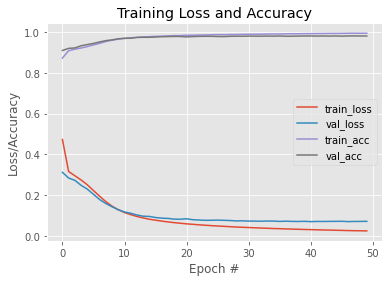

In [8]:
tf.keras.backend.clear_session()

((trainX, trainY), (testX, testY)) = mnist.load_data()

trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

trainX = np.expand_dims(trainX, -1)
testX = np.expand_dims(testX, -1)

trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

model = ShallowNet.build(28, 28, 1, 32, 10)
model.compile(loss = 'categorical_crossentropy', optimizer = SGD(0.01), metrics = ['accuracy'])
print(model.summary())

print("[INFO] training network...")
maxIt = 50
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 32, epochs = maxIt, verbose = 1)

print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, maxIt), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, maxIt), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, maxIt), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, maxIt), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

Let's try it with the Adam optimizer.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
activation_2 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                250890    
_________________________________________________________________
activation_3 (Activation)    (None, 10)                0         
Total params: 251,210
Trainable params: 251,210
Non-trainable params: 0
_________________________________________________________________
None
[INFO] training network...
Epoch 1/20
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3578

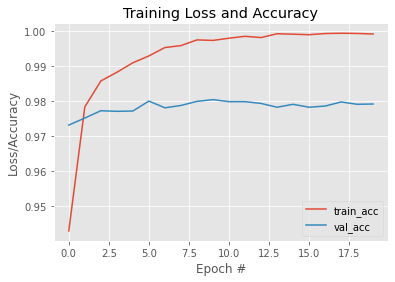

In [9]:
((trainX, trainY), (testX, testY)) = mnist.load_data()

trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

trainX = np.expand_dims(trainX, -1)
testX = np.expand_dims(testX, -1)

trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

model = ShallowNet.build(28, 28, 1, 32, 10)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

print("[INFO] training network...")
maxIt = 20
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 32, epochs = maxIt, verbose = 1)

print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, maxIt), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, maxIt), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

Clearly, even this *tiny* CNN is amazing with MNIST, so let's try it on a harder problem: classifying CIFAR-10

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_4 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                327690    
_________________________________________________________________
activation_5 (Activation)    (None, 10)                0         
Total params: 328,586
Trainable params: 328,586
Non-trainable params: 0
_________________________________________________________________
None
[INFO] training network...
Epoch 1/20
313/313 [==============================] - 2s 5ms/step - loss: 1.8451 -

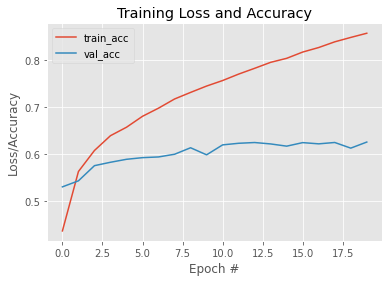

In [10]:
((trainX, trainY), (testX, testY)) = cifar10.load_data()

trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

model = ShallowNet.build(32, 32, 3, 32, 10)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

print("[INFO] training network...")
maxIt = 20
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 128, epochs = maxIt, verbose = 1)

print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))
print(model.summary())

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure
plt.plot(np.arange(0, maxIt), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, maxIt), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

This is significantly better performance than we saw with fully-connected nets last week, reaching over 60\% accuracy.

### LeNet

The first CNN that was considered particularly practical is what has become known as LeNet (named after Yann LeCun, who developed it along with his collaborators). The implementation below is a somewhat larger version of LeCun's net, which outperforms a bit better.

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten

class LeNet:
    # create the architecture
    def build(height, width, depth, classes):
        # create a feedforward neural net
        model = Sequential()
        
        # add a convolutional layer with 20 5x5 filters and a 2x2 max pooling layer
        model.add(Conv2D(32, (5, 5), padding = 'same', input_shape = (height, width, depth)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        
        # add another convolutional layer with 50 5x5 filters and a 2x2 max pooling layer
        model.add(Conv2D(64, (5, 5), padding= 'same'))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        
        # add another convolutional layer
        model.add(Conv2D(128, (5, 5), padding = 'same'))
        model.add(Activation('relu'))
        
        # add a fully-connected layer
        model.add(Flatten())
        model.add(Dense(500))
        model.add(Activation('relu'))
        
        # add a softmax classifier
        model.add(Dense(classes))
        model.add(Activation('softmax'))
        
        # return the constructed model
        return model

### LeNet for Classifying MNIST

Let's run the model on MNIST.

[INFO] training network...
Epoch 1/100
375/375 [==============================] - 2s 5ms/step - loss: 0.1515 - accuracy: 0.9514 - val_loss: 0.0461 - val_accuracy: 0.9861
Epoch 2/100
375/375 [==============================] - 2s 5ms/step - loss: 0.0397 - accuracy: 0.9880 - val_loss: 0.0382 - val_accuracy: 0.9883
Epoch 3/100
375/375 [==============================] - 2s 5ms/step - loss: 0.0267 - accuracy: 0.9912 - val_loss: 0.0347 - val_accuracy: 0.9892
Epoch 4/100
375/375 [==============================] - 2s 5ms/step - loss: 0.0203 - accuracy: 0.9935 - val_loss: 0.0469 - val_accuracy: 0.9858
Epoch 5/100
375/375 [==============================] - 2s 4ms/step - loss: 0.0162 - accuracy: 0.9944 - val_loss: 0.0349 - val_accuracy: 0.9897
Epoch 6/100
375/375 [==============================] - 2s 4ms/step - loss: 0.0114 - accuracy: 0.9965 - val_loss: 0.0367 - val_accuracy: 0.9915
Epoch 7/100
375/375 [==============================] - 2s 4ms/step - loss: 0.0105 - accuracy: 0.9965 - val_loss: 0.

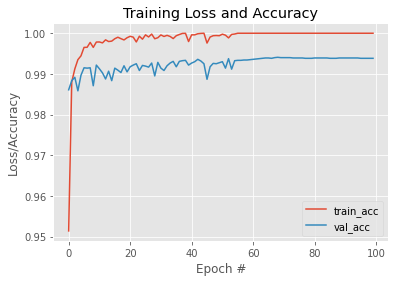

In [16]:
tf.keras.backend.clear_session()

((trainX, trainY), (testX, testY)) = mnist.load_data()

trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

trainX = np.expand_dims(trainX, -1)
testX = np.expand_dims(testX, -1)

trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

model = LeNet.build(28, 28, 1, 10)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

print("[INFO] training network...")
maxIt = 100
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 128, epochs = maxIt, verbose = 1)
print(model.summary())

print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, maxIt), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, maxIt), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

LeNet is incredibly on MNIST, getting approximately 99.4\% test accuracy with zero tuning.

### LeNet for Classifying CIFAR-10

[INFO] training network...
Epoch 1/10
313/313 [==============================] - 2s 6ms/step - loss: 1.5818 - accuracy: 0.4236 - val_loss: 1.3291 - val_accuracy: 0.5202
Epoch 2/10
313/313 [==============================] - 2s 5ms/step - loss: 1.1459 - accuracy: 0.5925 - val_loss: 1.1351 - val_accuracy: 0.6073
Epoch 3/10
313/313 [==============================] - 2s 5ms/step - loss: 0.9349 - accuracy: 0.6711 - val_loss: 0.9523 - val_accuracy: 0.6650
Epoch 4/10
313/313 [==============================] - 2s 5ms/step - loss: 0.7812 - accuracy: 0.7259 - val_loss: 0.8591 - val_accuracy: 0.6981
Epoch 5/10
313/313 [==============================] - 2s 5ms/step - loss: 0.6456 - accuracy: 0.7759 - val_loss: 0.8516 - val_accuracy: 0.7097
Epoch 6/10
313/313 [==============================] - 2s 5ms/step - loss: 0.5129 - accuracy: 0.8205 - val_loss: 0.9141 - val_accuracy: 0.7056
Epoch 7/10
313/313 [==============================] - 2s 5ms/step - loss: 0.3763 - accuracy: 0.8698 - val_loss: 0.9367 - 

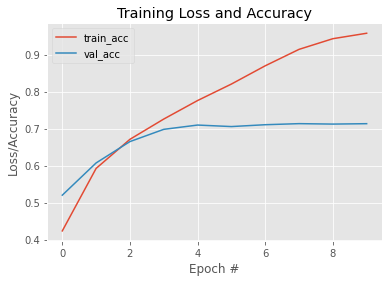

In [20]:
tf.keras.backend.clear_session()

((trainX, trainY), (testX, testY)) = cifar10.load_data()

trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

model = LeNet.build(32, 32, 3, 10)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

print("[INFO] training network...")
maxIt = 10
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 128, epochs = maxIt, verbose = 1)
print(model.summary())

print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, maxIt), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, maxIt), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

We have now reached 71\% test accuracy on CIFAR-10, a gain of 20 percentage points since the previous lecture even though we have done nothing to tune the model!

Whats more, it took only 10 iterations with a runtime of about 21 seconds. This is partly due to the sparsity of CNNs and partially due to the Adam optimizer converging very quickly.

### Regularized LeNet

Let's try adding regularization in the form of elastic-net and dropout to see if it helps the overfitting we see with both MNIST and CIFAR-10.

In [30]:
tf.keras.backend.clear_session()
    
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.regularizers import l1_l2

class LeNetReg:
    # create the architecture
    def build(height, width, depth, classes, lam1 = 0, lam2 = 0, dropout = [0, 0, 0, 0.5]):
        # create a feedforward neural net
        model = Sequential()
        
        # add a convolutional layer with 20 5x5 filters and a 2x2 max pooling layer
        model.add(Conv2D(32, (5, 5), padding = 'same', input_shape = (height, width, depth),
                         kernel_regularizer = l1_l2(l1 = lam1, l2 = lam2)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        model.add(Dropout(dropout[0]))
        
        # add another convolutional layer with 50 5x5 filters and a 2x2 max pooling layer
        model.add(Conv2D(64, (5, 5), padding= 'same', kernel_regularizer = l1_l2(l1 = lam1, l2 = lam2)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        model.add(Dropout(dropout[1]))
        
        # add another convolutional layer
        model.add(Conv2D(128, (5, 5), padding = 'same', kernel_regularizer = l1_l2(l1 = lam1, l2 = lam2)))
        model.add(Activation('relu'))
        model.add(Dropout(dropout[2]))
        
        # add a fully-connected layer
        model.add(Flatten())
        model.add(Dense(500))
        model.add(Activation('relu'))
        
        model.add(Dropout(dropout[3]))
        
        # add a softmax classifier
        model.add(Dense(classes))
        model.add(Activation('softmax'))
        
        # return the constructed model
        return model

Let's run it on MNIST to see if we can improve our (incredible) 99.4% accuracy!

[INFO] training network...
Epoch 1/100
375/375 [==============================] - 2s 5ms/step - loss: 0.1726 - accuracy: 0.9453 - val_loss: 0.0434 - val_accuracy: 0.9872
Epoch 2/100
375/375 [==============================] - 2s 4ms/step - loss: 0.0472 - accuracy: 0.9854 - val_loss: 0.0376 - val_accuracy: 0.9893
Epoch 3/100
375/375 [==============================] - 2s 4ms/step - loss: 0.0324 - accuracy: 0.9903 - val_loss: 0.0360 - val_accuracy: 0.9894
Epoch 4/100
375/375 [==============================] - 2s 5ms/step - loss: 0.0237 - accuracy: 0.9922 - val_loss: 0.0370 - val_accuracy: 0.9887
Epoch 5/100
375/375 [==============================] - 2s 4ms/step - loss: 0.0180 - accuracy: 0.9943 - val_loss: 0.0347 - val_accuracy: 0.9904
Epoch 6/100
375/375 [==============================] - 2s 4ms/step - loss: 0.0153 - accuracy: 0.9951 - val_loss: 0.0307 - val_accuracy: 0.9916
Epoch 7/100
375/375 [==============================] - 2s 4ms/step - loss: 0.0124 - accuracy: 0.9962 - val_loss: 0.

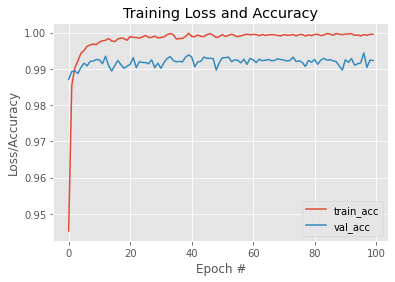

In [18]:
tf.keras.backend.clear_session()

((trainX, trainY), (testX, testY)) = mnist.load_data()

trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

trainX = np.expand_dims(trainX, -1)
testX = np.expand_dims(testX, -1)

trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

model = LeNetReg.build(28, 28, 1, 10)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

print("[INFO] training network...")
maxIt = 100
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 128, epochs = maxIt, verbose = 1)

print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

print(model.summary())

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
# plt.plot(np.arange(0, maxIt), H.history["loss"], label="train_loss")
# plt.plot(np.arange(0, maxIt), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, maxIt), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, maxIt), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

This is slightly worse, but note the noise in the graphs coming from the extra randomness we added with dropout. This is usually a good thing because it means we were likely searching the parameter space more widely.

Let's try it with CIFAR-10.

[INFO] training network...
Epoch 1/100
313/313 [==============================] - 2s 6ms/step - loss: 1.6714 - accuracy: 0.3855 - val_loss: 1.3087 - val_accuracy: 0.5280
Epoch 2/100
313/313 [==============================] - 2s 5ms/step - loss: 1.2275 - accuracy: 0.5621 - val_loss: 1.0870 - val_accuracy: 0.6143
Epoch 3/100
313/313 [==============================] - 2s 5ms/step - loss: 1.0179 - accuracy: 0.6413 - val_loss: 0.9414 - val_accuracy: 0.6732
Epoch 4/100
313/313 [==============================] - 2s 5ms/step - loss: 0.8660 - accuracy: 0.6958 - val_loss: 0.8790 - val_accuracy: 0.6928
Epoch 5/100
313/313 [==============================] - 2s 5ms/step - loss: 0.7448 - accuracy: 0.7383 - val_loss: 0.8455 - val_accuracy: 0.7085
Epoch 6/100
313/313 [==============================] - 2s 5ms/step - loss: 0.6440 - accuracy: 0.7751 - val_loss: 0.8193 - val_accuracy: 0.7177
Epoch 7/100
313/313 [==============================] - 2s 5ms/step - loss: 0.5496 - accuracy: 0.8073 - val_loss: 0.

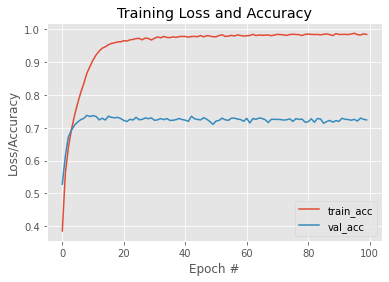

In [19]:
tf.keras.backend.clear_session()

((trainX, trainY), (testX, testY)) = cifar10.load_data()

trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

model = LeNetReg.build(32, 32, 3, 10)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

print("[INFO] training network...")
maxIt = 100
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 128, epochs = maxIt, verbose = 1)

print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

print(model.summary())

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
# plt.plot(np.arange(0, maxIt), H.history["loss"], label="train_loss")
# plt.plot(np.arange(0, maxIt), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, maxIt), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, maxIt), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

We see a slight improvement, up to 72.5\%. Let's go back to SGD and see how it compares.

[INFO] training network...
Epoch 1/100
313/313 [==============================] - 2s 5ms/step - loss: 2.2127 - accuracy: 0.1631 - val_loss: 2.0199 - val_accuracy: 0.2798
Epoch 2/100
313/313 [==============================] - 2s 5ms/step - loss: 1.9852 - accuracy: 0.2808 - val_loss: 1.9094 - val_accuracy: 0.3187
Epoch 3/100
313/313 [==============================] - 2s 5ms/step - loss: 1.8270 - accuracy: 0.3454 - val_loss: 1.7846 - val_accuracy: 0.3591
Epoch 4/100
313/313 [==============================] - 2s 5ms/step - loss: 1.7128 - accuracy: 0.3848 - val_loss: 1.7132 - val_accuracy: 0.3863
Epoch 5/100
313/313 [==============================] - 2s 5ms/step - loss: 1.6315 - accuracy: 0.4159 - val_loss: 1.6068 - val_accuracy: 0.4308
Epoch 6/100
313/313 [==============================] - 2s 5ms/step - loss: 1.5745 - accuracy: 0.4348 - val_loss: 1.5156 - val_accuracy: 0.4584
Epoch 7/100
313/313 [==============================] - 2s 5ms/step - loss: 1.5298 - accuracy: 0.4527 - val_loss: 1.

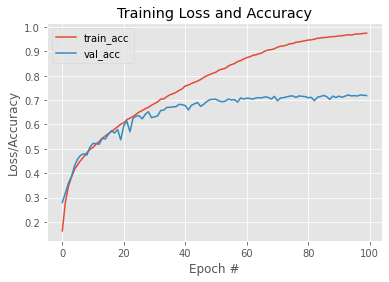

In [20]:
tf.keras.backend.clear_session()

((trainX, trainY), (testX, testY)) = cifar10.load_data()

trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

model = LeNetReg.build(32, 32, 3, 10)
model.compile(loss = 'categorical_crossentropy', optimizer = SGD(0.01), metrics = ['accuracy'])

print("[INFO] training network...")
maxIt = 100
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 128, epochs = maxIt, verbose = 1)

print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

print(model.summary())

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
# plt.plot(np.arange(0, maxIt), H.history["loss"], label="train_loss")
# plt.plot(np.arange(0, maxIt), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, maxIt), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, maxIt), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

We got similar results with SGD.

Some next steps might be to try regularization. Let's try weight decay (L1 and L2 penalties) since we are seeing overfitting.

In [31]:
tf.keras.backend.clear_session()

from sklearn.metrics import accuracy_score

((trainX, trainY), (testX, testY)) = cifar10.load_data()

trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

best_hyperparameters = [0, 0]
best_accuracy = 0

for l1 in [0, 0.001, 0.01, 0.1]:
    for l2 in [0, 0.001, 0.01, 0.1]:
        
        model = LeNetReg.build(32, 32, 3, 10, l1/trainX.shape[0], l2/trainX.shape[0])
        model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

        maxIt = 20
        H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 128, epochs = maxIt, verbose = 0)
        dev_accuracy = H.history['val_accuracy'][-1]
        print('Dev accuracy for l1 =', l1, ', l2 =', l2, 'is', dev_accuracy)
        
        if dev_accuracy > best_accuracy: best_hyperparameters = [l1, l2]

Dev accuracy for l1 = 0 , l2 = 0 is 0.7096385359764099
Dev accuracy for l1 = 0 , l2 = 0.001 is 0.7015662789344788
Dev accuracy for l1 = 0 , l2 = 0.01 is 0.701084315776825
Dev accuracy for l1 = 0 , l2 = 0.1 is 0.7119277119636536
Dev accuracy for l1 = 0.001 , l2 = 0 is 0.7203614711761475
Dev accuracy for l1 = 0.001 , l2 = 0.001 is 0.7019277215003967
Dev accuracy for l1 = 0.001 , l2 = 0.01 is 0.7151806950569153
Dev accuracy for l1 = 0.001 , l2 = 0.1 is 0.6980723142623901
Dev accuracy for l1 = 0.01 , l2 = 0 is 0.7015662789344788
Dev accuracy for l1 = 0.01 , l2 = 0.001 is 0.7206023931503296
Dev accuracy for l1 = 0.01 , l2 = 0.01 is 0.7136144638061523
Dev accuracy for l1 = 0.01 , l2 = 0.1 is 0.7203614711761475
Dev accuracy for l1 = 0.1 , l2 = 0 is 0.724457859992981
Dev accuracy for l1 = 0.1 , l2 = 0.001 is 0.7174698710441589
Dev accuracy for l1 = 0.1 , l2 = 0.01 is 0.715542197227478
Dev accuracy for l1 = 0.1 , l2 = 0.1 is 0.7301204800605774


In [34]:
best_hyperparameters

[0.1, 0.1]

Epoch 1/15
313/313 [==============================] - 3s 7ms/step - loss: 1.6556 - accuracy: 0.3910 - val_loss: 1.3348 - val_accuracy: 0.5338
Epoch 2/15
313/313 [==============================] - 2s 6ms/step - loss: 1.2408 - accuracy: 0.5611 - val_loss: 1.0868 - val_accuracy: 0.6153
Epoch 3/15
313/313 [==============================] - 2s 6ms/step - loss: 1.0171 - accuracy: 0.6445 - val_loss: 0.9896 - val_accuracy: 0.6613
Epoch 4/15
313/313 [==============================] - 2s 6ms/step - loss: 0.8729 - accuracy: 0.6971 - val_loss: 0.8617 - val_accuracy: 0.7015
Epoch 5/15
313/313 [==============================] - 2s 6ms/step - loss: 0.7731 - accuracy: 0.7344 - val_loss: 0.8311 - val_accuracy: 0.7178
Epoch 6/15
313/313 [==============================] - 2s 6ms/step - loss: 0.6772 - accuracy: 0.7663 - val_loss: 0.8410 - val_accuracy: 0.7190
Epoch 7/15
313/313 [==============================] - 2s 6ms/step - loss: 0.5975 - accuracy: 0.7956 - val_loss: 0.8188 - val_accuracy: 0.7310
Epoch 

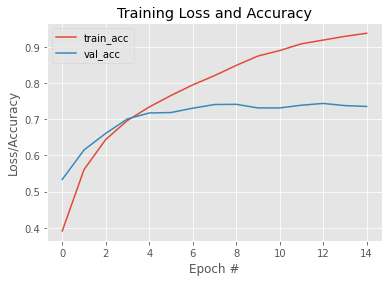

In [39]:
((trainX, trainY), (testX, testY)) = cifar10.load_data()

trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

model = LeNetReg.build(32, 32, 3, 10, 0.1/trainX.shape[0], 0.1/trainX.shape[0])
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

maxIt = 15
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 128, epochs = maxIt)

print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis = 1)
testY = testY.argmax(axis = 1)
print(classification_report(testY, predictedY))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, maxIt), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, maxIt), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

Here, we gained a couple percentage points, reaching 73.5\% test accuracy!

Let's try modifying the Dropout hyperparameters.

In [28]:
tf.keras.backend.clear_session()

from sklearn.metrics import accuracy_score

((trainX, trainY), (testX, testY)) = cifar10.load_data()

trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

for dropout in [[0.1, 0.1, 0.1, 0.5], [0.2, 0.2, 0.2, 0.5], [0.5, 0.5, 0.5, 0.5]]:
        
    model = LeNetReg.build(32, 32, 3, 10, dropout = dropout)
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

    maxIt = 20
    H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 128, epochs = maxIt)
    print('Dev accuracy for dropout percentages', dropout, 'is', H.history['val_accuracy'][-1])

Epoch 1/20
260/260 [==============================] - 2s 6ms/step - loss: 1.6871 - accuracy: 0.3814 - val_loss: 1.3464 - val_accuracy: 0.5089
Epoch 2/20
260/260 [==============================] - 2s 6ms/step - loss: 1.2934 - accuracy: 0.5357 - val_loss: 1.1195 - val_accuracy: 0.6051
Epoch 3/20
260/260 [==============================] - 2s 6ms/step - loss: 1.0986 - accuracy: 0.6101 - val_loss: 1.0322 - val_accuracy: 0.6370
Epoch 4/20
260/260 [==============================] - 2s 6ms/step - loss: 0.9578 - accuracy: 0.6618 - val_loss: 0.9217 - val_accuracy: 0.6806
Epoch 5/20
260/260 [==============================] - 2s 6ms/step - loss: 0.8328 - accuracy: 0.7087 - val_loss: 0.8749 - val_accuracy: 0.6982
Epoch 6/20
260/260 [==============================] - 2s 6ms/step - loss: 0.7470 - accuracy: 0.7372 - val_loss: 0.8650 - val_accuracy: 0.7064
Epoch 7/20
260/260 [==============================] - 2s 6ms/step - loss: 0.6575 - accuracy: 0.7719 - val_loss: 0.9204 - val_accuracy: 0.6955
Epoch 

Dev accuracy jumped to 74.6\% by adding Dropout after the pooling layers.

Epoch 1/20
313/313 [==============================] - 2s 6ms/step - loss: 1.7037 - accuracy: 0.3714 - val_loss: 1.3635 - val_accuracy: 0.5176
Epoch 2/20
313/313 [==============================] - 2s 6ms/step - loss: 1.2851 - accuracy: 0.5375 - val_loss: 1.0910 - val_accuracy: 0.6100
Epoch 3/20
313/313 [==============================] - 2s 6ms/step - loss: 1.0940 - accuracy: 0.6112 - val_loss: 0.9479 - val_accuracy: 0.6684
Epoch 4/20
313/313 [==============================] - 2s 6ms/step - loss: 0.9680 - accuracy: 0.6608 - val_loss: 0.9428 - val_accuracy: 0.6736
Epoch 5/20
313/313 [==============================] - 2s 6ms/step - loss: 0.8782 - accuracy: 0.6906 - val_loss: 0.8273 - val_accuracy: 0.7113
Epoch 6/20
313/313 [==============================] - 2s 6ms/step - loss: 0.8009 - accuracy: 0.7182 - val_loss: 0.7913 - val_accuracy: 0.7278
Epoch 7/20
313/313 [==============================] - 2s 6ms/step - loss: 0.7349 - accuracy: 0.7396 - val_loss: 0.7788 - val_accuracy: 0.7303
Epoch 

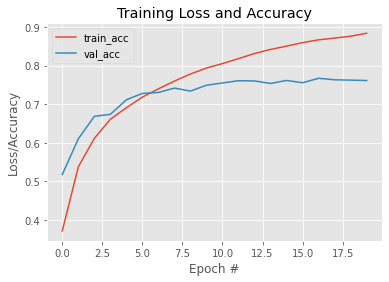

In [40]:
tf.keras.backend.clear_session()

from sklearn.metrics import accuracy_score

((trainX, trainY), (testX, testY)) = cifar10.load_data()

trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

model = LeNetReg.build(32, 32, 3, 10, dropout = [0.2, 0.2, 0.2, 0.5])
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

maxIt = 20
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 128, epochs = maxIt)

print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis = 1)
testY = testY.argmax(axis = 1)
print(classification_report(testY, predictedY))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, maxIt), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, maxIt), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

We improve even further to about 75\% test accuracy.

For a final test, let's try L1, L2, and enhanced dropout.

Epoch 1/50
313/313 [==============================] - 3s 7ms/step - loss: 1.7014 - accuracy: 0.3767 - val_loss: 1.3609 - val_accuracy: 0.5076
Epoch 2/50
313/313 [==============================] - 2s 7ms/step - loss: 1.3059 - accuracy: 0.5325 - val_loss: 1.1676 - val_accuracy: 0.5900
Epoch 3/50
313/313 [==============================] - 2s 7ms/step - loss: 1.1440 - accuracy: 0.5979 - val_loss: 1.0128 - val_accuracy: 0.6423
Epoch 4/50
313/313 [==============================] - 2s 7ms/step - loss: 1.0224 - accuracy: 0.6441 - val_loss: 0.9565 - val_accuracy: 0.6665
Epoch 5/50
313/313 [==============================] - 2s 7ms/step - loss: 0.9471 - accuracy: 0.6722 - val_loss: 0.8748 - val_accuracy: 0.6988
Epoch 6/50
313/313 [==============================] - 2s 7ms/step - loss: 0.8674 - accuracy: 0.7003 - val_loss: 0.8937 - val_accuracy: 0.6921
Epoch 7/50
313/313 [==============================] - 2s 7ms/step - loss: 0.8142 - accuracy: 0.7200 - val_loss: 0.8935 - val_accuracy: 0.6974
Epoch 

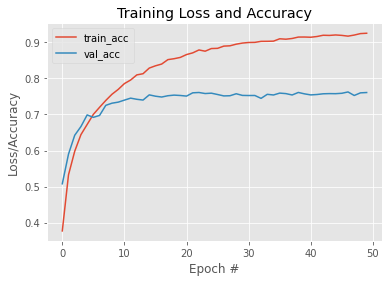

In [43]:
tf.keras.backend.clear_session()

from sklearn.metrics import accuracy_score

((trainX, trainY), (testX, testY)) = cifar10.load_data()

trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

n = trainX.shape[0]

model = LeNetReg.build(32, 32, 3, 10, lam1 = 0.1/n, lam2 = 0.1/n, dropout = [0.2, 0.2, 0.2, 0.5])
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

maxIt = 50
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 128, epochs = maxIt)

print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis = 1)
testY = testY.argmax(axis = 1)
print(classification_report(testY, predictedY))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, maxIt), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, maxIt), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

The performance is still above 75\%, sometimes hitting 76\%, which is great!

## Lecture 14 - Oct 7 - AlexNet, VGGNet

### AlexNet

In [52]:
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import numpy as np
import os
import shutil

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

In [8]:
class AlexNet:
    def build(height, width, depth, classes, lambda2 = 0.0002):
        model = Sequential(name = 'AlexNet')
        
        model.add(Conv2D(96, (11, 11), strides = (4, 4), input_shape = (height, width, depth),
                         padding='same', kernel_regularizer = l2(lambda2)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size = (3,3), strides = (2,2)))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(256, (5, 5), padding = 'same', kernel_regularizer = l2(lambda2)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size = (3, 3), strides = (2, 2)))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(384, (3, 3), padding = 'same', kernel_regularizer = l2(lambda2)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv2D(384, (3, 3), padding = 'same', kernel_regularizer = l2(lambda2)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv2D(256, (3, 3), padding = 'same', kernel_regularizer = l2(lambda2)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size = (3, 3), strides = (2, 2)))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        
        model.add(Dense(4096, kernel_regularizer = l2(lambda2)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        model.add(Dense(4096, kernel_regularizer = l2(lambda2)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        model.add(Dense(classes, kernel_regularizer = l2(lambda2)))
        model.add(Activation('softmax'))
        
        return model

In [9]:
tf.keras.backend.clear_session()

from tensorflow.keras.optimizers import Adam

model = AlexNet.build(227, 227, 3, 1000)
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])

print(model.summary())

Model: "AlexNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 57, 57, 96)        34944     
_________________________________________________________________
activation (Activation)      (None, 57, 57, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 57, 57, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 96)        0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 256)       614656    
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 256)       0   

### MiniVGGNet

In [10]:
class MiniVGGNet:
    def build(height, width, depth, classes):
        model = Sequential(name = 'MiniVGGNet')
        
        model.add(Conv2D(32, (3, 3), padding = 'same', input_shape = (height, width, depth)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv2D(32, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(64, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv2D(64, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        
        model.add(Dense(512))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        model.add(Dense(classes))
        model.add(Activation('softmax'))
        
        return model

Model: "MiniVGGNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0

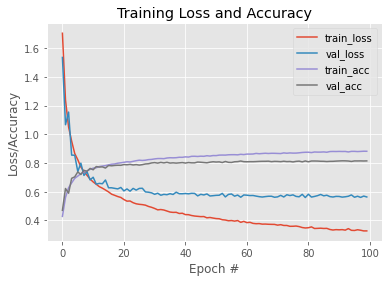

In [18]:
tf.keras.backend.clear_session()

((trainX, trainY), (testX, testY)) = cifar10.load_data()

trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

model = MiniVGGNet.build(32, 32, 3, 10)
opt = SGD(learning_rate = 0.01, decay = 0.1 / 100, momentum = 0.9, nesterov = True)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

print(model.summary())

print("[INFO] training network...")
maxIt = 100
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 64, epochs = maxIt, verbose = 1)

print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, maxIt), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, maxIt), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, maxIt), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, maxIt), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

### VGGNet16 and VGGNet19

These nets can be expensive to run, but let's write classes for them.

In [19]:
class VGGNet16:
    def build(height, width, depth, classes):
        model = Sequential(name = 'VGGNet16')
        
        # conv 1
        model.add(Conv2D(64, (3, 3), padding = 'same', input_shape = (height, width, depth)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # conv 2
        model.add(Conv2D(64, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # pool
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        model.add(Dropout(0.25))
        
        # conv 3
        model.add(Conv2D(128, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # conv 4
        model.add(Conv2D(128, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # pool
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        model.add(Dropout(0.25))
        
        # conv 5
        model.add(Conv2D(256, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # conv 6
        model.add(Conv2D(256, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # conv 7
        model.add(Conv2D(256, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # pool
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        model.add(Dropout(0.25))
        
        # conv 8
        model.add(Conv2D(512, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # conv 9
        model.add(Conv2D(512, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # conv 10
        model.add(Conv2D(512, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # pool
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        model.add(Dropout(0.25))
        
        # conv 11
        model.add(Conv2D(512, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # conv 12
        model.add(Conv2D(512, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # conv 13
        model.add(Conv2D(512, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # pool
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        
        # fc 14
        model.add(Dense(4096))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        # fc 15
        model.add(Dense(4096))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        # fc 16
        model.add(Dense(1000))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation('softmax'))
        
        # return the model
        return model

Let's take a look at the size of the model.

In [20]:
model = VGGNet16.build(224, 224, 3, 1000)
model.compile(loss = 'categorical_crossentropy', optimizer = SGD(0.01), metrics = ['accuracy'])

print(model.summary())

Model: "VGGNet16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
activation_6 (Activation)    (None, 224, 224, 64)      0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
activation_7 (Activation)    (None, 224, 224, 64)      0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 64)      0  

In [23]:
class VGGNet19:
    def build(height, width, depth, classes):
        model = Sequential(name = 'VGGNet19')
        
        # conv 1
        model.add(Conv2D(64, (3, 3), padding = 'same', input_shape = (height, width, depth)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # conv 2
        model.add(Conv2D(64, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # pool
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        model.add(Dropout(0.25))
        
        # conv 3
        model.add(Conv2D(128, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # conv 4
        model.add(Conv2D(128, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # pool
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        model.add(Dropout(0.25))
        
        # conv 5
        model.add(Conv2D(256, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # conv 6
        model.add(Conv2D(256, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # conv 7
        model.add(Conv2D(256, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # conv 8
        model.add(Conv2D(256, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # pool
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        model.add(Dropout(0.25))
        
        # conv 9
        model.add(Conv2D(512, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # conv 10
        model.add(Conv2D(512, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # conv 11
        model.add(Conv2D(512, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # conv 12
        model.add(Conv2D(512, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # pool
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        model.add(Dropout(0.25))
        
        # conv 13
        model.add(Conv2D(512, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # conv 14
        model.add(Conv2D(512, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # conv 15
        model.add(Conv2D(512, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # conv 16
        model.add(Conv2D(512, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # pool
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        
        # fc 17
        model.add(Dense(4096))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        # fc 18
        model.add(Dense(4096))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        # fc 19
        model.add(Dense(1000))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation('softmax'))
        
        # return the model
        return model

In [24]:
model = VGGNet19.build(224, 224, 3, 1000)
model.compile(loss = 'categorical_crossentropy', optimizer = SGD(0.01), metrics = ['accuracy'])

print(model.summary())

Model: "VGGNet19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
activation_43 (Activation)   (None, 224, 224, 64)      0         
_________________________________________________________________
batch_normalization_40 (Batc (None, 224, 224, 64)      256       
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
activation_44 (Activation)   (None, 224, 224, 64)      0         
_________________________________________________________________
batch_normalization_41 (Batc (None, 224, 224, 64)      256       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 112, 112, 64)      0  

### Image Preprocessing

In [127]:
# Write a class for data preprocessing and loading (This is for images, but a similar procedure
# is a good idea for any dataset stored in separate files)
import cv2
import os
import numpy as np
from imutils import paths
from random import randint

# image preprocessor
class SimpleImagePreprocessor:
    def __init__(self, width, height, cWidth = 0, cHeight = 0, cropAugment = 1, interpolation = cv2.INTER_AREA):
        # store target image width, height, and interpolation method for resizing
        self.width = width
        self.height = height
        self.cWidth = cWidth
        self.cHeight = cHeight
        self.interpolation = interpolation
        self.cropAugment = cropAugment
        self.translationAugment = 0
        
    def resize(self, image):
        # resize to a fixed size ignoring aspect ratio
        return [cv2.resize(image, (self.width, self.height), interpolation = self.interpolation)]
    
    # randomly crop an image nAugment times and return each
    def randomCrop(self, image):
        images = []
        
        image = image[0]
        
        # iterate from 0 to nAugment
        for counter in np.arange(0, self.cropAugment):
            # choose a random coordinates for the lower left corner of the image
            lowerLeftX = randint(0, self.width - self.cWidth)
            lowerLeftY = randint(0, self.height - self.cHeight)
            
            # crop the image from the random point to the specified size and append to a list of images
            images.append(image[lowerLeftY:lowerLeftY + self.cHeight, lowerLeftX:lowerLeftX + self.cWidth])
            
        # return the randomly cropped images
        return images
    
    def translate(self, image, pixels = 2):        
        # translate left, right, up, and down
        leftImage = np.roll(image, pixels)
        rightImage = np.roll(image, -pixels)
        upImage = np.roll(image, pixels, axis = 0)
        downImage = np.roll(image, -pixels, axis = 0)
        
        images = [image, leftImage, rightImage, upImage, downImage]
                
        # return images translated in each direction
        return images
        
# image dataset loader
class SimpleImageDatasetLoader:
    def __init__(self, cropAugment = 1, preprocessors = None):
        self.cropAugment = cropAugment
        self.translationAugment = 0
        
        # store the image preprocessor
        self.preprocessors = preprocessors
        
        # if there are no preprocessors, initialize as an empty list
        if self.preprocessors is None:
            self.preprocessors = []
            
        if preprocessor.translate in self.preprocessors:
            self.translationAugment = 4
            
    def load(self, imagePaths, verbose = -1, bw = 0):
        # initialize the list of features and labels
        data = []
        labels = []
        
        
        # loop over the input images
        for (i, imagePath) in enumerate(imagePaths):
            # load an image and extract the class label from the path
            if bw == 1:
                image = cv2.imread(imagePath, cv2.IMREAD_GRAYSCALE)
            else:
                image = cv2.imread(imagePath)
            
            # if there are image preprocessors, apply them to the image
            if self.preprocessors is not None:
                
                # loop over the preprocessors
                for p in self.preprocessors:                    
                    # apply the preprocessor
                    image = p(image)
            
            #print(imagePath)
            label = imagePath.split(os.path.sep)[-2]
            label = (self.cropAugment + self.translationAugment) * [label]
            
            # save the data and labels
            data.extend(image)
            labels.extend(label)
                        
            # give some updates on the preprocessing
            if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
                print('[INFO] processed {}/{}'.format(i + 1, len(imagePaths)))
                
        # return the data and labels in numpy arrays
        return (np.array(data), np.array(labels))

### MNIST with Data Augmentation

Let's extract the MNIST data into `.jpg` files.

In [1]:
!python mnist_jpg.py mnist

writing mnist\training\5\0.jpg
writing mnist\training\0\1.jpg
writing mnist\training\4\2.jpg
writing mnist\training\1\3.jpg
writing mnist\training\9\4.jpg
writing mnist\training\2\5.jpg
writing mnist\training\1\6.jpg
writing mnist\training\3\7.jpg
writing mnist\training\1\8.jpg
writing mnist\training\4\9.jpg
writing mnist\training\3\10.jpg
writing mnist\training\5\11.jpg
writing mnist\training\3\12.jpg
writing mnist\training\6\13.jpg
writing mnist\training\1\14.jpg
writing mnist\training\7\15.jpg
writing mnist\training\2\16.jpg
writing mnist\training\8\17.jpg
writing mnist\training\6\18.jpg
writing mnist\training\9\19.jpg
writing mnist\training\4\20.jpg
writing mnist\training\0\21.jpg
writing mnist\training\9\22.jpg
writing mnist\training\1\23.jpg
writing mnist\training\1\24.jpg
writing mnist\training\2\25.jpg
writing mnist\training\4\26.jpg
writing mnist\training\3\27.jpg
writing mnist\training\2\28.jpg
writing mnist\training\7\29.jpg
writing mnist\training\3\30.jpg
writing mnist\trai

Let's start with classifying MNIST 

In [33]:
print('[INFO] loading images...')
# save the paths to all the images
imagePaths = list(paths.list_images(os.getcwd() + '/mnist/training'))
imagePaths = imagePaths + list(paths.list_images(os.getcwd() + '/mnist/testing'))

# initialize the preprocessor
preprocessor = SimpleImagePreprocessor(28, 28)

# choose preprocessors to use in the data loader
dataLoader = SimpleImageDatasetLoader(1, preprocessors = [preprocessor.translate])

# from each image preprocess to add 4 new images, shifted 1 pixel in each direction
# (increases data + labels by a factor of 5)
(data, labels) = dataLoader.load(imagePaths, verbose = 1000, bw = 1)

[INFO] loading images...
[INFO] processed 1000/70000
[INFO] processed 2000/70000
[INFO] processed 3000/70000
[INFO] processed 4000/70000
[INFO] processed 5000/70000
[INFO] processed 6000/70000
[INFO] processed 7000/70000
[INFO] processed 8000/70000
[INFO] processed 9000/70000
[INFO] processed 10000/70000
[INFO] processed 11000/70000
[INFO] processed 12000/70000
[INFO] processed 13000/70000
[INFO] processed 14000/70000
[INFO] processed 15000/70000
[INFO] processed 16000/70000
[INFO] processed 17000/70000
[INFO] processed 18000/70000
[INFO] processed 19000/70000
[INFO] processed 20000/70000
[INFO] processed 21000/70000
[INFO] processed 22000/70000
[INFO] processed 23000/70000
[INFO] processed 24000/70000
[INFO] processed 25000/70000
[INFO] processed 26000/70000
[INFO] processed 27000/70000
[INFO] processed 28000/70000
[INFO] processed 29000/70000
[INFO] processed 30000/70000
[INFO] processed 31000/70000
[INFO] processed 32000/70000
[INFO] processed 33000/70000
[INFO] processed 34000/7000

In [34]:
sData = data
print(sData.shape)

sLabels = labels
print(sLabels.shape)

(350000, 28, 28)
(350000,)


[INFO] training network...
Epoch 1/25
1641/1641 [==============================] - 9s 5ms/step - loss: 0.0656 - accuracy: 0.9794 - val_loss: 0.0201 - val_accuracy: 0.9935
Epoch 2/25
1641/1641 [==============================] - 8s 5ms/step - loss: 0.0186 - accuracy: 0.9940 - val_loss: 0.0252 - val_accuracy: 0.9925
Epoch 3/25
1641/1641 [==============================] - 8s 5ms/step - loss: 0.0129 - accuracy: 0.9959 - val_loss: 0.0169 - val_accuracy: 0.9949
Epoch 4/25
1641/1641 [==============================] - 8s 5ms/step - loss: 0.0093 - accuracy: 0.9971 - val_loss: 0.0119 - val_accuracy: 0.9963
Epoch 5/25
1641/1641 [==============================] - 8s 5ms/step - loss: 0.0077 - accuracy: 0.9975 - val_loss: 0.0079 - val_accuracy: 0.9976
Epoch 6/25
1641/1641 [==============================] - 8s 5ms/step - loss: 0.0065 - accuracy: 0.9980 - val_loss: 0.0088 - val_accuracy: 0.9974
Epoch 7/25
1641/1641 [==============================] - 8s 5ms/step - loss: 0.0056 - accuracy: 0.9983 - val_l

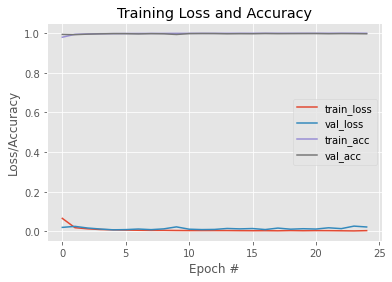

In [35]:
tf.keras.backend.clear_session()

# scale the data to [0,1]
sData = data.astype('float32')/255.0

# store labels as integers
sLabels = labels.astype('uint8')

# encode the labels as one-hot
sLabels = to_categorical(sLabels, 10)

# split data into train and test data
(trainX, testX, trainY, testY) = train_test_split(sData, sLabels, test_size = 0.25)

# ensure data is in the right shape
trainX = np.expand_dims(trainX, -1)
testX = np.expand_dims(testX, -1)

# build and compile a LeNet-5 model
model = LeNet.build(28, 28, 1, 10)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

print("[INFO] training network...")

# fit the model
maxIt = 25
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 128, epochs = maxIt, verbose = 1)

# print a model summary
print(model.summary())

# print a classification report
print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY, digits=5))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, maxIt), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, maxIt), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, maxIt), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, maxIt), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

We have an incredible 99.7\% accuracy here! Let's try MiniVGGNet.

[INFO] training network...
Epoch 1/25
1641/1641 [==============================] - 13s 8ms/step - loss: 0.0907 - accuracy: 0.9723 - val_loss: 0.0276 - val_accuracy: 0.9911
Epoch 2/25
1641/1641 [==============================] - 12s 7ms/step - loss: 0.0347 - accuracy: 0.9889 - val_loss: 0.0208 - val_accuracy: 0.9935
Epoch 3/25
1641/1641 [==============================] - 12s 8ms/step - loss: 0.0270 - accuracy: 0.9914 - val_loss: 0.0182 - val_accuracy: 0.9938
Epoch 4/25
1641/1641 [==============================] - 12s 8ms/step - loss: 0.0221 - accuracy: 0.9931 - val_loss: 0.0138 - val_accuracy: 0.9958
Epoch 5/25
1641/1641 [==============================] - 12s 7ms/step - loss: 0.0198 - accuracy: 0.9937 - val_loss: 0.0138 - val_accuracy: 0.9958
Epoch 6/25
1641/1641 [==============================] - 12s 7ms/step - loss: 0.0166 - accuracy: 0.9949 - val_loss: 0.0116 - val_accuracy: 0.9960
Epoch 7/25
1641/1641 [==============================] - 12s 7ms/step - loss: 0.0138 - accuracy: 0.9955 

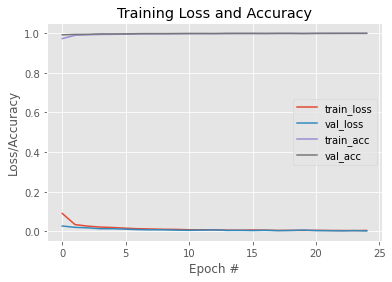

In [38]:
tf.keras.backend.clear_session()

# scale the data to [0,1]
sData = data.astype('float32')/255.0

# store labels as integers
sLabels = labels.astype('uint8')

# encode the labels as one-hot
sLabels = to_categorical(sLabels, 10)

# split data into train and test data
(trainX, testX, trainY, testY) = train_test_split(sData, sLabels, test_size = 0.25)

# ensure data is in the right shape
trainX = np.expand_dims(trainX, -1)
testX = np.expand_dims(testX, -1)

# build and compile a LeNet-5 model
model = MiniVGGNet.build(28, 28, 1, 10)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

print("[INFO] training network...")

# fit the model
maxIt = 25
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 128, epochs = maxIt, verbose = 1)

# print a classification report
print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY, digits=5))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, maxIt), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, maxIt), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, maxIt), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, maxIt), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

Next, delete the MNIST images. We only do this so the code can be stored in GitHub.

In [42]:
shutil.rmtree('mnist')

### Dogs vs. Cats

Let's test these nets along with the preprocessor and data loader on the Dogs vs. Cats dataset from Kaggle (https://www.kaggle.com/c/dogs-vs-cats). This is a higher dimensional dataset than we have used in the past, with image sizes ranging from 50x50 to 500x500 in all different aspect ratios. We will simply distort them to be square images to see how it works.

This is a pretty challenging dataset because we have cats of all different colors and from different angles while the dogs come from many diffrent breeds, in different colors, and so on. CNNs are particularly well-suited to image recognition, so we will try a few modern CNN architectures with the dataset.

The code below assumes the dataset is stored in `../data/dogs-vs-cats/`, i.e. in the data folder one level up from this notebook file.

#### 32x32 Experiment

First, let's load the images and resize them all to 32x32.

In [61]:
# load the images from a folder within the current working directory
print('[INFO] loading images...')

imagePaths = list(paths.list_images('../data/dogs-vs-cats'))

# chose the size for the image
preprocessor = SimpleImagePreprocessor(32, 32)

# initialize the data loader
dataLoader = SimpleImageDatasetLoader(1, preprocessors = [preprocessor.resize])

# load the data into lists
(data, labels) = dataLoader.load(imagePaths, verbose = 1000)

[INFO] loading images...
[INFO] processed 1000/25000
[INFO] processed 2000/25000
[INFO] processed 3000/25000
[INFO] processed 4000/25000
[INFO] processed 5000/25000
[INFO] processed 6000/25000
[INFO] processed 7000/25000
[INFO] processed 8000/25000
[INFO] processed 9000/25000
[INFO] processed 10000/25000
[INFO] processed 11000/25000
[INFO] processed 12000/25000
[INFO] processed 13000/25000
[INFO] processed 14000/25000
[INFO] processed 15000/25000
[INFO] processed 16000/25000
[INFO] processed 17000/25000
[INFO] processed 18000/25000
[INFO] processed 19000/25000
[INFO] processed 20000/25000
[INFO] processed 21000/25000
[INFO] processed 22000/25000
[INFO] processed 23000/25000
[INFO] processed 24000/25000
[INFO] processed 25000/25000


In [63]:
# save the labels as sLabels to avoid overwriting the data loader output below
sData = data
print(sData.shape)

sLabels = labels
print(sLabels.shape)

(25000, 32, 32, 3)
(25000,)


Let's encode the data and shrink the data values to be in [0,1].

In [64]:
# encode the labels as integers
sLabels = LabelEncoder().fit_transform(sLabels)

# encode the labels as one-hot
sLabels = to_categorical(sLabels, 2)

# split data into train and test data
(trainX, testX, trainY, testY) = train_test_split(sData, sLabels, test_size = 0.25)

# Scale the data to [0,1]
trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

Let's run MiniVGGNet and see how it performs!

Model: "MiniVGGNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0

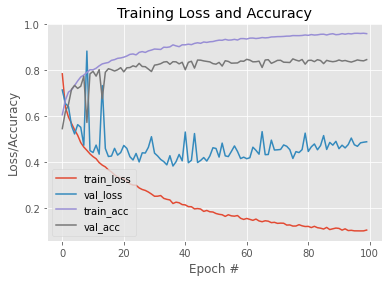

In [65]:
# clear GPU
tf.keras.backend.clear_session()

# build and compile the net
model = MiniVGGNet.build(32, 32, 3, 2)
opt = SGD(learning_rate = 0.01, decay = 0.1 / 100, momentum = 0.9, nesterov = True)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

# print a summary of the model
print(model.summary())

# train the network
print("[INFO] training network...")
maxIt = 100
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 128, epochs = maxIt, verbose = 1)

# compute a classification report on the test data
print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, maxIt), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, maxIt), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, maxIt), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, maxIt), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

This is pretty good for a first try--we get 84% accuracy on the test set and the graph reveals the net seemed to converge pretty well but with some overfitting.

#### 64x64 Experiment

Let's try the same approach with 64x64 images to see if the extra data helps.

In [66]:
# clear GPU
tf.keras.backend.clear_session()

print('[INFO] loading images...')

imagePaths = list(paths.list_images('../data/dogs-vs-cats'))

preprocessor = SimpleImagePreprocessor(64, 64)

dataLoader = SimpleImageDatasetLoader(1, preprocessors = [preprocessor.resize])

(data, labels) = dataLoader.load(imagePaths, verbose = 1000)

[INFO] loading images...
[INFO] processed 1000/25000
[INFO] processed 2000/25000
[INFO] processed 3000/25000
[INFO] processed 4000/25000
[INFO] processed 5000/25000
[INFO] processed 6000/25000
[INFO] processed 7000/25000
[INFO] processed 8000/25000
[INFO] processed 9000/25000
[INFO] processed 10000/25000
[INFO] processed 11000/25000
[INFO] processed 12000/25000
[INFO] processed 13000/25000
[INFO] processed 14000/25000
[INFO] processed 15000/25000
[INFO] processed 16000/25000
[INFO] processed 17000/25000
[INFO] processed 18000/25000
[INFO] processed 19000/25000
[INFO] processed 20000/25000
[INFO] processed 21000/25000
[INFO] processed 22000/25000
[INFO] processed 23000/25000
[INFO] processed 24000/25000
[INFO] processed 25000/25000


In [67]:
sLabels = labels

# encode the labels as integers
sLabels = LabelEncoder().fit_transform(sLabels)

# encode the labels as one-hot
sLabels = to_categorical(sLabels, 2)

# split data into train and test data
(trainX, testX, trainY, testY) = train_test_split(data, sLabels, test_size = 0.25)

# Scale the data to [0,1]
trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

Let's try MiniVGGNet again, but with the Adam optimizer.

Model: "MiniVGGNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0

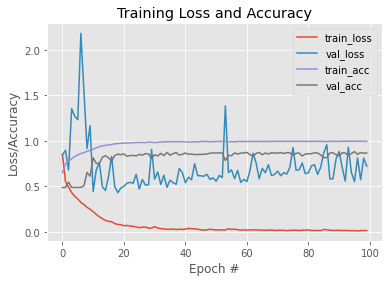

In [68]:
# clear GPU
tf.keras.backend.clear_session()

# build and compile the net
model = MiniVGGNet.build(64, 64, 3, 2)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# print a summary of the model
print(model.summary())

# train the network
print("[INFO] training network...")
maxIt = 100
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 256, epochs = maxIt, verbose = 1)

# compute a classification report on the test data
print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, maxIt), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, maxIt), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, maxIt), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, maxIt), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

We see a slight improvement with 84% accuracy on the test set. We again see some noise in the training, but performance is pretty good.

#### 227 x 227 Experiment 1 with AlexNet

Let's try it out with much larger images of size 227x227, which was used originally with AlexNet, but with the Adam optimizer.

In [69]:
print('[INFO] loading images...')

imagePaths = list(paths.list_images('../data/dogs-vs-cats'))

preprocessor = SimpleImagePreprocessor(227, 227)

dataLoader = SimpleImageDatasetLoader(1, preprocessors = [preprocessor.resize])

(data, labels) = dataLoader.load(imagePaths, verbose = 1000)

[INFO] loading images...
[INFO] processed 1000/25000
[INFO] processed 2000/25000
[INFO] processed 3000/25000
[INFO] processed 4000/25000
[INFO] processed 5000/25000
[INFO] processed 6000/25000
[INFO] processed 7000/25000
[INFO] processed 8000/25000
[INFO] processed 9000/25000
[INFO] processed 10000/25000
[INFO] processed 11000/25000
[INFO] processed 12000/25000
[INFO] processed 13000/25000
[INFO] processed 14000/25000
[INFO] processed 15000/25000
[INFO] processed 16000/25000
[INFO] processed 17000/25000
[INFO] processed 18000/25000
[INFO] processed 19000/25000
[INFO] processed 20000/25000
[INFO] processed 21000/25000
[INFO] processed 22000/25000
[INFO] processed 23000/25000
[INFO] processed 24000/25000
[INFO] processed 25000/25000


In [76]:
sLabels = labels
sData = data

# encode the labels as integers
sLabels = LabelEncoder().fit_transform(sLabels)

# encode the labels as one-hot
sLabels = to_categorical(sLabels, 2)

# split data into train and test data
(trainX, testX, trainY, testY) = train_test_split(sData, sLabels, test_size = 0.25)

# Scale the data to [0,1]
trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

Model: "AlexNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 57, 57, 96)        34944     
_________________________________________________________________
activation (Activation)      (None, 57, 57, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 57, 57, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 96)        0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 256)       614656    
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 256)       0   

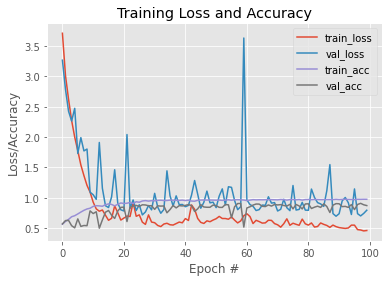

In [71]:
tf.keras.backend.clear_session()

model = AlexNet.build(227, 227, 3, 2)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

print(model.summary())

# train the network
print("[INFO] training network...")
maxIt = 100
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 128, epochs = maxIt, verbose = 1)

# compute a classification report on the test data
print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, maxIt), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, maxIt), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, maxIt), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, maxIt), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

#### 227x227 Experiment 2 with AlexNet

This time, let's use SGD with momentum and Nesterov acceleration.

In [77]:
print('[INFO] loading images...')

imagePaths = list(paths.list_images('../data/dogs-vs-cats'))

preprocessor = SimpleImagePreprocessor(227, 227)

dataLoader = SimpleImageDatasetLoader(1, preprocessors = [preprocessor.resize])

(data, labels) = dataLoader.load(imagePaths, verbose = 1000)

[INFO] loading images...
[INFO] processed 1000/25000
[INFO] processed 2000/25000
[INFO] processed 3000/25000
[INFO] processed 4000/25000
[INFO] processed 5000/25000
[INFO] processed 6000/25000
[INFO] processed 7000/25000
[INFO] processed 8000/25000
[INFO] processed 9000/25000
[INFO] processed 10000/25000
[INFO] processed 11000/25000
[INFO] processed 12000/25000
[INFO] processed 13000/25000
[INFO] processed 14000/25000
[INFO] processed 15000/25000
[INFO] processed 16000/25000
[INFO] processed 17000/25000
[INFO] processed 18000/25000
[INFO] processed 19000/25000
[INFO] processed 20000/25000
[INFO] processed 21000/25000
[INFO] processed 22000/25000
[INFO] processed 23000/25000
[INFO] processed 24000/25000
[INFO] processed 25000/25000


Model: "AlexNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 57, 57, 96)        34944     
_________________________________________________________________
activation_16 (Activation)   (None, 57, 57, 96)        0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 57, 57, 96)        384       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 28, 28, 96)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 28, 28, 96)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 256)       614656    
_________________________________________________________________
activation_17 (Activation)   (None, 28, 28, 256)       0   

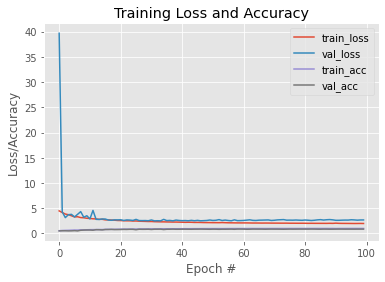

In [79]:
sLabels = labels
sData = data

# encode the labels as integers
sLabels = LabelEncoder().fit_transform(sLabels)

# encode the labels as one-hot
sLabels = to_categorical(sLabels, 2)

# split data into train and test data
(trainX, testX, trainY, testY) = train_test_split(sData, sLabels, test_size = 0.25)

# Scale the data to [0,1]
trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

model = AlexNet.build(227, 227, 3, 2)
opt = SGD(learning_rate = 0.01, decay = 0.1 / 100, momentum = 0.9, nesterov = True)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

print(model.summary())

# train the network
print("[INFO] training network...")
maxIt = 100
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 128, epochs = maxIt, verbose = 1)

# compute a classification report on the test data
print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, maxIt), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, maxIt), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, maxIt), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, maxIt), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

Here, we see a small improvement with 88% accuracy on the test set, 1% better performance with SGD than with Adam. This is similar to the approach Krizhevsky et. al. used in their ImageNet-winning work of 2012.

#### 227x227 Experiment 3 with AlexNet (Random Cropping)

Another method used by Krishevsky et. al. was to resize all images to 256x256 and then randomly crop a 227x227 window from the image. Let's see if this helps right away as it might help us avoid some bias associated with the location of the animal in the frame. 

In [106]:
print('[INFO] loading images...')

imagePaths = list(paths.list_images('../data/dogs-vs-cats'))

preprocessor = SimpleImagePreprocessor(256, 256, 227, 227, 1)

dataLoader = SimpleImageDatasetLoader(1, preprocessors = [preprocessor.resize, preprocessor.randomCrop])

(data, labels) = dataLoader.load(imagePaths, verbose = 1000)

[INFO] loading images...
[INFO] processed 1000/25000
[INFO] processed 2000/25000
[INFO] processed 3000/25000
[INFO] processed 4000/25000
[INFO] processed 5000/25000
[INFO] processed 6000/25000
[INFO] processed 7000/25000
[INFO] processed 8000/25000
[INFO] processed 9000/25000
[INFO] processed 10000/25000
[INFO] processed 11000/25000
[INFO] processed 12000/25000
[INFO] processed 13000/25000
[INFO] processed 14000/25000
[INFO] processed 15000/25000
[INFO] processed 16000/25000
[INFO] processed 17000/25000
[INFO] processed 18000/25000
[INFO] processed 19000/25000
[INFO] processed 20000/25000
[INFO] processed 21000/25000
[INFO] processed 22000/25000
[INFO] processed 23000/25000
[INFO] processed 24000/25000
[INFO] processed 25000/25000


Model: "AlexNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 57, 57, 96)        34944     
_________________________________________________________________
activation (Activation)      (None, 57, 57, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 57, 57, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 96)        0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 256)       614656    
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 256)       0   

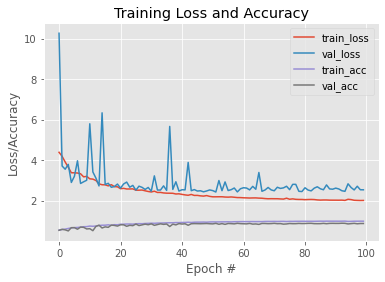

In [ ]:
sLabels = labels
sData = data

# encode the labels as integers
sLabels = LabelEncoder().fit_transform(sLabels)

# encode the labels as one-hot
sLabels = to_categorical(sLabels, 2)

# split data into train and test data
(trainX, testX, trainY, testY) = train_test_split(sData, sLabels, test_size = 0.25)

# Scale the data to [0,1]
trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

tf.keras.backend.clear_session()

model = AlexNet.build(227, 227, 3, 2)
opt = SGD(learning_rate = 0.01, decay = 0.1 / 100, momentum = 0.9, nesterov = True)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

print(model.summary())

# train the network
print("[INFO] training network...")
maxIt = 100
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 128, epochs = maxIt, verbose = 1)

# compute a classification report on the test data
print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, maxIt), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, maxIt), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, maxIt), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, maxIt), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

### 227x227 Experiment 4 with AlexNet (Random Cropping + Data Augmentation)

It seems random cropping did not really help, but perhaps we can use it to generate extra data by cropping several different windows of each image, which we may be able to exploit to get better performance on our test set.

In [128]:
print('[INFO] loading images...')

imagePaths = list(paths.list_images('../data/dogs-vs-cats'))

preprocessor = SimpleImagePreprocessor(256, 256, 227, 227, 4)

# crop 4 random windows from the image (more may be better if more RAM permitted it)
dataLoader = SimpleImageDatasetLoader(4, preprocessors = [preprocessor.resize, preprocessor.randomCrop, preprocessor.translate])

(data, labels) = dataLoader.load(imagePaths, verbose = 1000)

[INFO] loading images...


TypeError: list.append() takes no keyword arguments

In [129]:
sData = data
print(sData.shape)

sLabels = labels
print(sLabels.shape)

(125000, 4, 227, 227, 3)
(200000,)


In [130]:
sLabels = labels
sData = data

# encode the labels as integers
sLabels = LabelEncoder().fit_transform(sLabels)

# encode the labels as one-hot
sLabels = to_categorical(sLabels, 2)

# split data into train and test data
(trainX, testX, trainY, testY) = train_test_split(sData, sLabels, test_size = 0.25)

# Scale the data to [0,1]
trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

print(trainX.shape)

ValueError: Found input variables with inconsistent numbers of samples: [125000, 200000]

In [ ]:
tf.keras.backend.clear_session()

model = AlexNet.build(227, 227, 3, 2)
opt = SGD(learning_rate = 0.01, decay = 0.1 / 100, momentum = 0.9, nesterov = True)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

print(model.summary())

# train the network
print("[INFO] training network...")
maxIt = 100
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 64, epochs = maxIt, verbose = 1)

# compute a classification report on the test data
print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, maxIt), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, maxIt), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, maxIt), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, maxIt), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()